In [1]:
import zipfile
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier
from IPython.display import Audio
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import SVC

C:\Users\valen\AppData\Local\Temp\ipykernel_12576\1866427825.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
data_dir = "./wav"

# Load and preprocess audio data using spectrograms
labels = os.listdir(data_dir)
audio_data = []
target_labels = []

emotion_map = {
    'W': 'anger',
    'L': 'boredom',
    'E': 'disgust',
    'A': 'fear',
    'F': 'happiness',
    'N': 'neutral',
    'T': 'sadness'
}

spectrogrammisé et labellé tt les fichiers audio

In [3]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveforms for sound in emotions{}'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # transformer de Fourier
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for sounds with emotions{}'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()
    
def create_mfcc(data,sr,e):
    mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13)
    plt.figure(figsize=(12,3))
    plt.title('Mel-frequency cepstral coefficients for voices with emotion{}'.format(e), size=15)
    librosa.display.specshow(mfcc, x_axis='time')
    plt.ylabel('MFCC')
    plt.colorbar()

In [4]:
for audio_file in os.listdir(data_dir):
    audio_path = os.path.join(data_dir, audio_file)
    y, sr = librosa.load(audio_path, duration=3)  # Load audio and limit to 3 seconds
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    # Transpose the spectrogram to have the shape (timesteps, n_mels)
    spectrogram = spectrogram.T
    audio_data.append(spectrogram)
    speaker = audio_file[0:2]
    text_code = audio_file[2:6]
    emotion = audio_file[6]
    version = audio_file[7] if len(audio_file) > 7 else None
    label = f"{speaker}{text_code}{emotion}{version}"
    target_labels.append(label)

In [5]:
audio_file_tab = []
#construire le tableau des emotions:
emotion_tab = []
for i in range(len(target_labels)):
    emo = target_labels[i][5]
    emotion_tab.append(emotion_map[emo])
    audio_file_tab.append(os.path.join(data_dir, f'{target_labels[i]}wav'))
emotion_tab
print(emotion_tab)
print(audio_file_tab)
    

['happiness', 'neutral', 'anger', 'happiness', 'neutral', 'sadness', 'anger', 'anger', 'fear', 'happiness', 'boredom', 'neutral', 'sadness', 'anger', 'fear', 'happiness', 'neutral', 'sadness', 'anger', 'anger', 'happiness', 'happiness', 'boredom', 'neutral', 'anger', 'happiness', 'boredom', 'neutral', 'sadness', 'anger', 'anger', 'fear', 'boredom', 'neutral', 'sadness', 'anger', 'neutral', 'sadness', 'anger', 'boredom', 'neutral', 'sadness', 'anger', 'fear', 'disgust', 'neutral', 'neutral', 'anger', 'anger', 'fear', 'happiness', 'boredom', 'neutral', 'anger', 'anger', 'fear', 'fear', 'happiness', 'boredom', 'neutral', 'sadness', 'anger', 'happiness', 'boredom', 'neutral', 'sadness', 'anger', 'happiness', 'boredom', 'neutral', 'sadness', 'anger', 'happiness', 'boredom', 'neutral', 'sadness', 'sadness', 'anger', 'fear', 'happiness', 'happiness', 'boredom', 'neutral', 'anger', 'happiness', 'boredom', 'neutral', 'sadness', 'anger', 'happiness', 'boredom', 'neutral', 'sadness', 'anger', 'fe

## Rajouter du bruit

In [6]:
#BRUIT 
def noise(data,noise_rate=0.01):
    noise_amp = 0.01*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

#CHANGEMENT DE VITESSE
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

#DECALAGE TEMPOREL
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

#CHANGER LA TONALITE
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

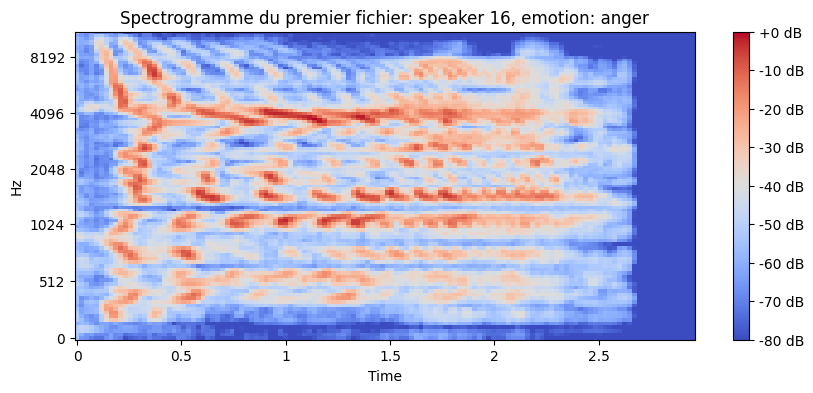

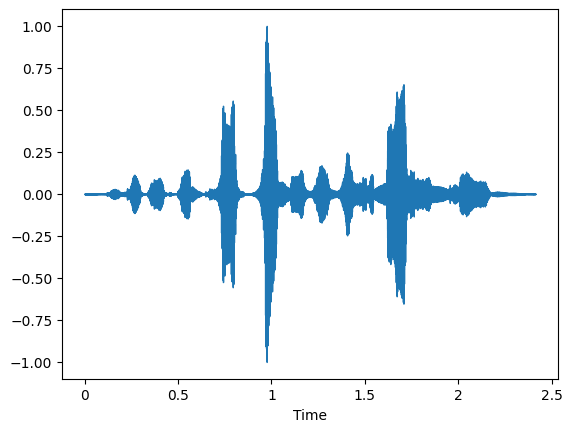

In [39]:
choix = random.randint(0, 534)
plt.figure(figsize=(10, 4))
librosa.display.specshow(audio_data[choix], x_axis='time', y_axis='mel', cmap='coolwarm')
speaker0 = target_labels[choix][0:2]
emotion0 = emotion_tab[choix]
plt.colorbar(format='%+2.0f dB')
plt.title(f'Spectrogramme du premier fichier: speaker {speaker0}, emotion: {emotion0}')
plt.show()

audio_file0 = os.path.join(data_dir, f'{target_labels[choix]}wav')
data0, sample_rate = librosa.load(audio_file0, sr=None)
librosa.display.waveshow(y=data0, sr=sample_rate)

Audio(audio_file0)

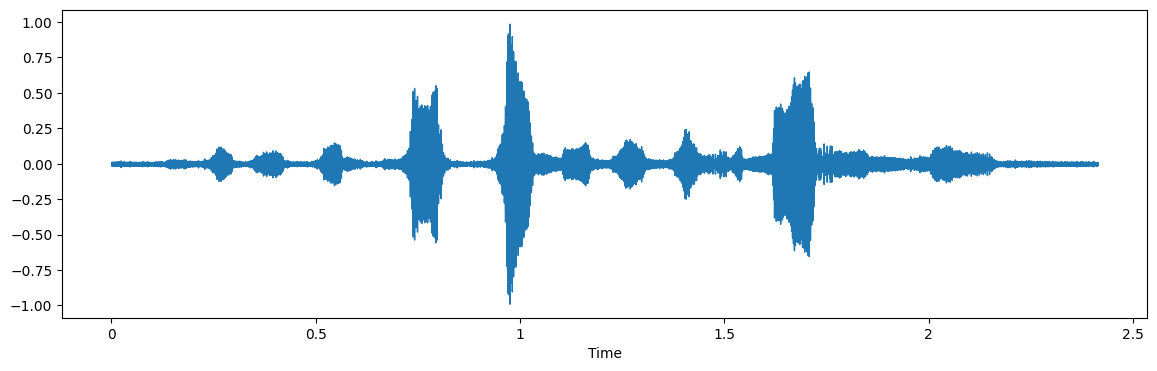

In [40]:
x = noise(data0)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

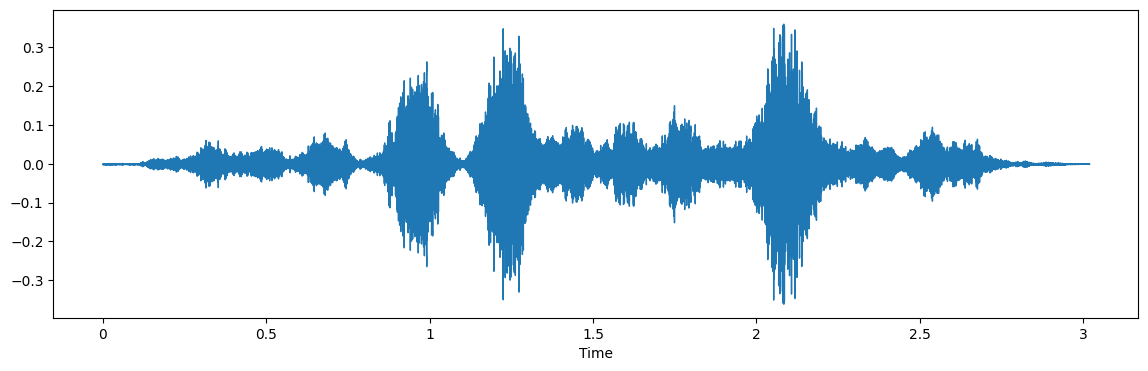

In [41]:
x = stretch(data0)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

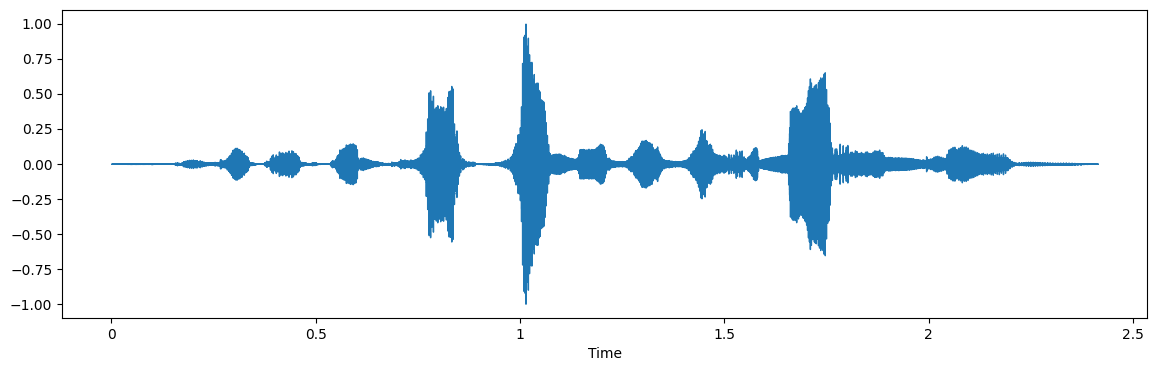

In [42]:
x = shift(data0)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

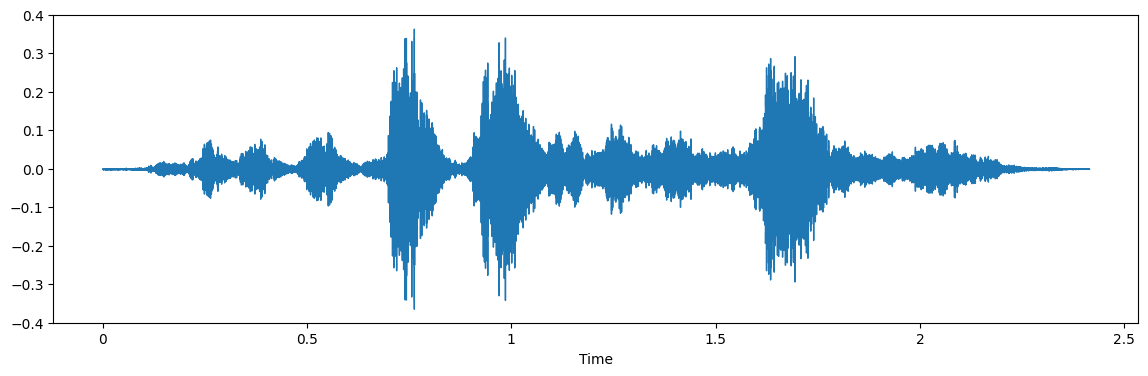

In [43]:
x = pitch(data0, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

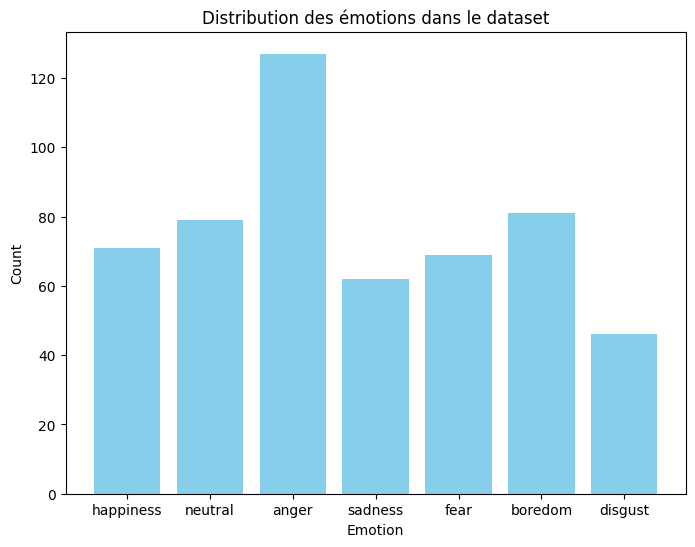

In [44]:
emotions_labels = [label[5] for label in target_labels]
emotion_values = [emotion_map.get(emotion, "Unknown") for emotion in emotions_labels]
emotion_counts = Counter(emotion_values)
plt.figure(figsize=(8, 6))
plt.bar(emotion_counts.keys(), emotion_counts.values(), color='skyblue')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution des émotions dans le dataset')
plt.show()

In [45]:
#transformer chaque signal en mfcc
def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

def extract_features(data, sr, frame_length=2048, hop_length=512):
    result = np.array([])
    
    result = np.hstack((result,
                        mfcc(data, sr, frame_length, hop_length)
                                    ))
    """
    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        rmse(data, frame_length, hop_length),
                        mfcc(data, sr, frame_length, hop_length)
                                    ))
    """
    return result

# Fonction d'augmentation des données pour le modèle
def get_features(path):
    # La durée et le décalage sont utilisés pour traiter les cas où il n'y a pas de son au début et à la fin de chaque fichier audio, comme expliqué ci-dessus.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # Données originales (sans modification)
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)
    
    # Données avec bruit ajouté
    noise_data = noise(data)  # Ajout de bruit
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2))  # Empilement des résultats
    
    # Données avec modification de la hauteur (pitch)
    data_pitch = pitch(data, sample_rate)  # Modification de la hauteur
    res3 = extract_features(data_pitch, sample_rate)
    result = np.vstack((result, res3))  # Empilement des résultats
    
    # Données avec bruit et modification de la hauteur combinés
    data_noise_pitch = noise(data_pitch)  # Ajout de bruit après modification de la hauteur
    res4 = extract_features(data_noise_pitch, sample_rate)
    result = np.vstack((result, res4))  # Empilement des résultats
    
    return result


X, Y = [], []
for path, emotion in zip(audio_file_tab, emotion_tab):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [46]:
path_repeated = [path for path in audio_file_tab for _ in range(4)]
print(path_repeated)

['./wav\\03a01Fa.wav', './wav\\03a01Fa.wav', './wav\\03a01Fa.wav', './wav\\03a01Fa.wav', './wav\\03a01Nc.wav', './wav\\03a01Nc.wav', './wav\\03a01Nc.wav', './wav\\03a01Nc.wav', './wav\\03a01Wa.wav', './wav\\03a01Wa.wav', './wav\\03a01Wa.wav', './wav\\03a01Wa.wav', './wav\\03a02Fc.wav', './wav\\03a02Fc.wav', './wav\\03a02Fc.wav', './wav\\03a02Fc.wav', './wav\\03a02Nc.wav', './wav\\03a02Nc.wav', './wav\\03a02Nc.wav', './wav\\03a02Nc.wav', './wav\\03a02Ta.wav', './wav\\03a02Ta.wav', './wav\\03a02Ta.wav', './wav\\03a02Ta.wav', './wav\\03a02Wb.wav', './wav\\03a02Wb.wav', './wav\\03a02Wb.wav', './wav\\03a02Wb.wav', './wav\\03a02Wc.wav', './wav\\03a02Wc.wav', './wav\\03a02Wc.wav', './wav\\03a02Wc.wav', './wav\\03a04Ad.wav', './wav\\03a04Ad.wav', './wav\\03a04Ad.wav', './wav\\03a04Ad.wav', './wav\\03a04Fd.wav', './wav\\03a04Fd.wav', './wav\\03a04Fd.wav', './wav\\03a04Fd.wav', './wav\\03a04Lc.wav', './wav\\03a04Lc.wav', './wav\\03a04Lc.wav', './wav\\03a04Lc.wav', './wav\\03a04Nc.wav', './wav\\0

In [47]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head(20)
Features['Path'] = path_repeated
Features.shape

(2140, 2162)

## Deep Learning 

In [49]:
import torch
from torch import nn, optim

encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
print(Y)
print(encoder)
print(encoder.classes_)

input_shape = (2160,)
num_classes = 7
num_epochs = 60
batch_size = 256
n_splits = 10

class AudioModel(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(AudioModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 256, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv1d(256, 256, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(256)
        self.pool2 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv1d(256, 128, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        self.dropout1 = nn.Dropout(0.2)
        self.conv4 = nn.Conv1d(128, 64, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm1d(64)
        self.pool4 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8640, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)
        x = self.pool3(x)
        x = self.dropout1(x)
        x = self.conv4(x)
        x = self.bn3(x)
        x = nn.functional.relu(x)
        x = self.pool4(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn4(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x
    
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

Features = Features.fillna(0)
X = Features.iloc[:, :-1].select_dtypes(include=[np.number]).values
Y = Features['labels'].values
print(X)
print(Y)


[4 4 4 ... 0 0 0]
LabelEncoder()
['anger' 'boredom' 'disgust' 'fear' 'happiness' 'neutral' 'sadness']
cuda
[[-311.23919678  144.43301392   36.91226959 ...    0.
     0.            0.        ]
 [-286.45867563  116.25094388   50.92571113 ...    0.
     0.            0.        ]
 [-308.27105713  145.07975769   35.57550812 ...    0.
     0.            0.        ]
 ...
 [-268.66849457   14.12058674    6.00134314 ...    0.
     0.            0.        ]
 [-300.4697876    53.90674591  -34.03083801 ...    0.
     0.            0.        ]
 [-275.85749266   24.40681365   -8.03063676 ...    0.
     0.            0.        ]]
['happiness' 'happiness' 'happiness' ... 'anger' 'anger' 'anger']


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.utils.data as data

Features = Features.fillna(0)

X_train, X_test, Y_train, Y_test, train_path, test_path = train_test_split(X, Y, path_repeated, test_size=0.2, random_state=42)


# Convertir les données en float32
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

# Convertir les labels en entiers
Y_train = encoder.fit_transform(Y_train)
Y_test = encoder.transform(Y_test)

# Convertir en tenseurs PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
Y_train = torch.tensor(Y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
Y_test = torch.tensor(Y_test, dtype=torch.long).to(device)

# Création de DataLoaders
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train.unsqueeze(1), Y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test.unsqueeze(1), Y_test), batch_size=batch_size, shuffle=False)

#Initialisation modèle
model = AudioModel(input_shape, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())


#Entrainement
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for inputs, targets in train_loader:      
        # Forward pass
        outputs = model(inputs)  
        loss = criterion(outputs, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1/60, Loss: 1.5473
Epoch 2/60, Loss: 1.1997
Epoch 3/60, Loss: 1.0431
Epoch 4/60, Loss: 0.9072
Epoch 5/60, Loss: 0.8040
Epoch 6/60, Loss: 0.7051
Epoch 7/60, Loss: 0.6061
Epoch 8/60, Loss: 0.5258
Epoch 9/60, Loss: 0.4387
Epoch 10/60, Loss: 0.3650
Epoch 11/60, Loss: 0.3185
Epoch 12/60, Loss: 0.2881
Epoch 13/60, Loss: 0.2501
Epoch 14/60, Loss: 0.2109
Epoch 15/60, Loss: 0.1752
Epoch 16/60, Loss: 0.1360
Epoch 17/60, Loss: 0.1240
Epoch 18/60, Loss: 0.1055
Epoch 19/60, Loss: 0.0947
Epoch 20/60, Loss: 0.0848
Epoch 21/60, Loss: 0.0723
Epoch 22/60, Loss: 0.0620
Epoch 23/60, Loss: 0.0574
Epoch 24/60, Loss: 0.0530
Epoch 25/60, Loss: 0.0459
Epoch 26/60, Loss: 0.0429
Epoch 27/60, Loss: 0.0404
Epoch 28/60, Loss: 0.0334
Epoch 29/60, Loss: 0.0318
Epoch 30/60, Loss: 0.0301
Epoch 31/60, Loss: 0.0289
Epoch 32/60, Loss: 0.0271
Epoch 33/60, Loss: 0.0248
Epoch 34/60, Loss: 0.0223
Epoch 35/60, Loss: 0.0211
Epoch 36/60, Loss: 0.0187
Epoch 37/60, Loss: 0.0187
Epoch 38/60, Loss: 0.0175
Epoch 39/60, Loss: 0.

## Evaluation et Tests

In [68]:
model.eval()
results = []
correct = 0
total = 0


emotion_labels = ['anger', 'boredom', 'disgust', 'fear', 'happiness', 'neutral', 'sadness']

with torch.no_grad():
    for i, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        batch_start = i * test_loader.batch_size
        batch_end = batch_start + inputs.size(0)
        batch_paths = test_path[batch_start:batch_end]
        
        outputs = model(inputs)
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
        _, predicted = torch.max(outputs, 1)
        
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        
        for i in range(inputs.size(0)):
            results.append({
            'file_name': batch_paths[i],  # Obtenir le fichier audio
            'real_emotion': emotion_labels[targets[i].item()],
            'predicted_emotion': emotion_labels[predicted[i].item()],
            'probabilities': {emotion: prob for emotion, prob in zip(emotion_labels, probabilities[i])}
            })
print(total)
print(correct)
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


428
426
Test Accuracy: 99.53%


In [65]:
choix = random.randint(0, len(results)-1)


audio0 = results[choix]['file_name']
emo = results[choix]['real_emotion']
predicted_emo = results[choix]['predicted_emotion']
proba = results[choix]['probabilities']
print(f"Audio aléatoire, émotion: {emo}")
Audio(audio0)
print(f"le modèle a prédit: {predicted_emo}, voici la distribution de probabilités pour chaque émotion: ")
print(proba)
for file in audio_file_tab:
    if file == audio0:
        a = file
print(audio0)
print(a)
Audio(a)


Audio aléatoire, émotion: sadness
le modèle a prédit: sadness, voici la distribution de probabilités pour chaque émotion: 
{'anger': 0.00064291083, 'boredom': 0.021553915, 'disgust': 0.0018328287, 'fear': 0.0006446726, 'happiness': 0.0004863384, 'neutral': 0.0005582292, 'sadness': 0.9742811}
./wav\14b03Ta.wav
./wav\14b03Ta.wav


## Interprétation et Analyse

## Adaptation de MocoV3

Exemple 0:


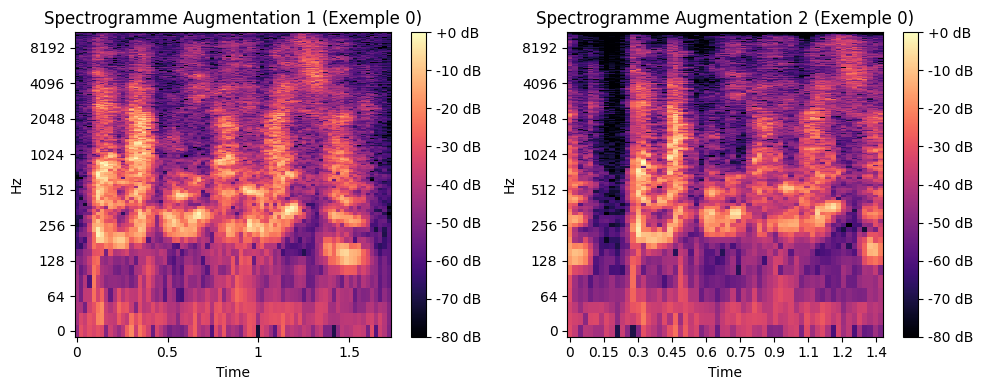

Exemple 1:


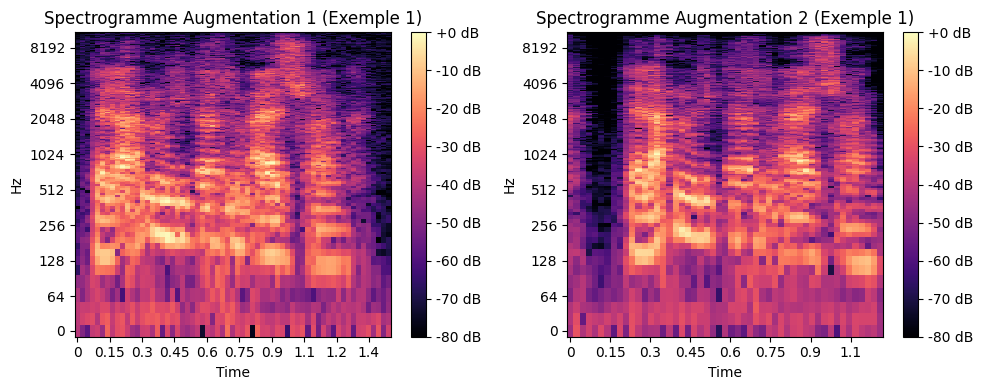

In [9]:
import librosa
import librosa.display
import numpy as np
import torchaudio
from torch.utils.data import Dataset

#adapter l'augmentation des données (par paire d'audio original)

def augment_audio(data, sampling_rate, augment_type):
    """
    Applique les augmentations spécifiées sur un fichier audio.
    
    Args:
    - data: Le signal audio (1D NumPy array).
    - sampling_rate: La fréquence d'échantillonnage du signal.
    - augment_type: Type d'augmentation ("noise_stretch" ou "shift_pitch").
    
    Returns:
    - Le signal audio transformé.
    """
    if augment_type == "noise_stretch":
        data = noise(data)
        data = stretch(data)
    elif augment_type == "shift_pitch":
        data = shift(data)
        data = pitch(data, sampling_rate)
    return data


class AudioDataset(Dataset):
    def __init__(self, file_paths, sr=16000, n_fft=1024, hop_length=512, transform=None):
        """
        Dataset pour charger des fichiers audio et générer des spectrogrammes augmentés.
        
        Args:
        - file_paths (list): Liste des chemins vers les fichiers audio.
        - sr (int): Fréquence d'échantillonnage (par défaut 16 kHz).
        - n_fft (int): Taille de la fenêtre FFT pour les spectrogrammes.
        - hop_length (int): Décalage entre les fenêtres FFT.
        - transform (callable, optional): Transformations supplémentaires (normalisation, etc.).
        """
        self.file_paths = file_paths
        self.sr = sr
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Charger le fichier audio
        file_path = self.file_paths[idx]
        waveform, sr = torchaudio.load(file_path)
        waveform = waveform[0].numpy()  # Convertir en NumPy array

        # Appliquer les augmentations
        augment1 = augment_audio(waveform, sr, "noise_stretch")
        augment2 = augment_audio(waveform, sr, "shift_pitch")

        # Convertir chaque augmentation en spectrogramme
        spectrogram1 = self._compute_spectrogram(augment1, sr)
        spectrogram2 = self._compute_spectrogram(augment2, sr)

        # Appliquer des transformations supplémentaires si nécessaires
        if self.transform:
            spectrogram1 = self.transform(spectrogram1)
            spectrogram2 = self.transform(spectrogram2)

        return (spectrogram1, spectrogram2), idx  # Retourne la paire et l'indice

    def _compute_spectrogram(self, data, sr):
        """
        Convertit un signal audio en spectrogramme.
        
        Args:
        - data (np.array): Signal audio brut.
        - sr (int): Fréquence d'échantillonnage.
        
        Returns:
        - np.array: Spectrogramme 2D.
        """
        # Calcul du spectrogramme
        spectrogram = librosa.stft(data, n_fft=self.n_fft, hop_length=self.hop_length)
        spectrogram = np.abs(spectrogram)  # Magnitude spectrale
        spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)  # Convertir en dB
        return spectrogram_db


#changer les loader (ligne 290 -> 302 de main_moco) et loader.py
dataset = AudioDataset(audio_file_tab, sr=16000)

for i in range(2):  # Afficher 2 exemples
    (augment1, augment2), idx = dataset[i]
    print(f"Exemple {i}:")
    
    # Affichage des spectrogrammes
    plt.figure(figsize=(10, 4))
    
    # Spectrogramme 1
    plt.subplot(1, 2, 1)
    librosa.display.specshow(augment1, x_axis='time', y_axis='log')
    plt.title(f"Spectrogramme Augmentation 1 (Exemple {i})")
    plt.colorbar(format='%+2.0f dB')
    
    # Spectrogramme 2
    plt.subplot(1, 2, 2)
    librosa.display.specshow(augment2, x_axis='time', y_axis='log')
    plt.title(f"Spectrogramme Augmentation 2 (Exemple {i})")
    plt.colorbar(format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()